# HMM Example Notebook

* Gaussian HMM
* Poisson HMM

In [1]:
%load_ext autoreload
%autoreload 2

#### Imports and Plotting Functions 

In [2]:
import jax.random as jr
import jax.numpy as np
import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp

from ssm.hmm import GaussianHMM, PoissonHMM
from ssm.plots import gradient_cmap
from ssm.utils import find_permutation
import warnings

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

def plot_transition_matrix(transition_matrix):
    plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
    plt.xlabel("next state")
    plt.ylabel("current state")
    plt.colorbar()
    plt.show()
    
def compare_transition_matrix(true_matrix, test_matrix):
    fig, axs = plt.subplots(1, 2)
    out = axs[0].imshow(true_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[1].imshow(test_matrix, vmin=0, vmax=1, cmap="Greys")
    axs[0].set_title("True Transition Matrix")
    axs[1].set_title("Test Transition Matrix")
    cax = fig.add_axes([axs[1].get_position().x1 + 0.07,
                        axs[1].get_position().y0,
                        0.02,
                        axs[1].get_position().y1-axs[1].get_position().y0])
    plt.colorbar(out, cax=cax)
    plt.show()

def plot_hmm_data(obs, states):
    lim = 1.01 * abs(obs).max()
    time_bins, obs_dim = obs.shape
    plt.figure(figsize=(8, 3))
    plt.imshow(states[None,:],
            aspect="auto",
            cmap=cmap,
            vmin=0,
            vmax=len(colors)-1,
            extent=(0, time_bins, -lim, (obs_dim)*lim))

    for d in range(obs_dim):
        plt.plot(obs[:,d] + lim * d, '-k')

    plt.xlim(0, time_bins)
    plt.xlabel("time")
    plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])

    plt.title("Simulated data from an HMM")

    plt.tight_layout()
    
def plot_posterior_states(Ez, states, perm):
    plt.figure(figsize=(20, 2))
    plt.imshow(Ez.T[perm], aspect="auto", interpolation="none", cmap="Greys")
    plt.plot(states, label="True State")
    plt.plot(Ez.T[perm].argmax(axis=0), '--', label="Predicted State")
    plt.xlabel("time")
    plt.ylabel("latent state")
    plt.legend(bbox_to_anchor=(1,1))
    plt.title("Predicted vs. Ground Truth Latent State")
    plt.show()

# 1: Gaussian HMM

#### First, let's create a ground truth HMM model

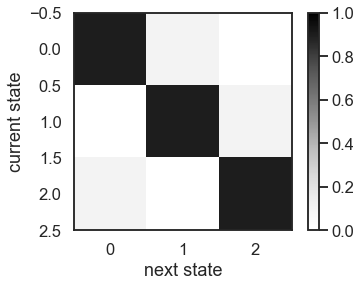

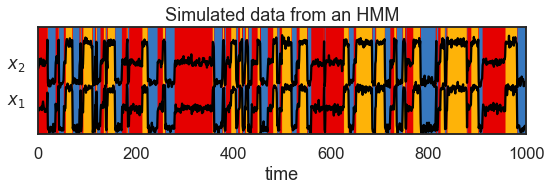

In [3]:
# define some parameters
num_states = 3
emission_dim = 2
initial_distribution = tfp.distributions.Categorical(logits=np.zeros(num_states))

transition_matrix = 0.9 * np.eye(num_states) \
                    + 0.1 * np.roll(np.eye(num_states), 1, axis=1)
transition_distribution = tfp.distributions.Categorical(probs=transition_matrix)

emission_means = np.arange(6, dtype=float).reshape((3, 2)) - 3
emission_scale_trils=0.25 * np.eye(emission_dim)
emission_distribution = tfp.distributions.MultivariateNormalTriL(emission_means, emission_scale_trils)

# create the model
true_hmm = GaussianHMM(
    num_states=num_states, 
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    emission_distribution=emission_distribution,
    )

# sample latent states, observations (data) from the model
num_timesteps = 1000
states, data = true_hmm.sample(jr.PRNGKey(0), num_timesteps)

# view the sampled data
plot_transition_matrix(transition_matrix)
plot_hmm_data(data, states)

## Fit Gaussian HMM using EM on a single trial

Initializing...
initializing with kmeans
Done.


  0%|          | 0/100 [00:00<?, ?it/s]

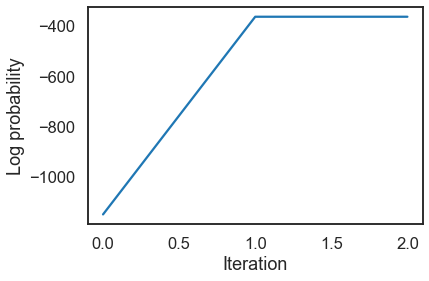

In [4]:
# we initialize a random HMM which we will fit to our data
seed = jr.PRNGKey(1)
num_states_est = 3

initial_distribution = tfp.distributions.Categorical(logits=np.zeros(num_states))
transition_distribution = tfp.distributions.Categorical(logits=np.zeros((num_states, num_states)))

emission_means = 3 * jr.normal(seed, shape=(num_states_est, 2))
emission_scale_trils = np.eye(emission_dim)
emission_distribution = tfp.distributions.MultivariateNormalTriL(emission_means, emission_scale_trils)

test_hmm = GaussianHMM(
    num_states=num_states, 
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    emission_distribution=emission_distribution,
    )

# fit the model using EM (for Gaussian HMM, we can perform exact EM)
log_probs, fitted_hmm, posterior = test_hmm.fit(data, method="em", tol=1e-5)

# plot the marginal log probability of the data as a function of number of fit steps
plt.plot(log_probs)
plt.ylabel("Log probability")
plt.xlabel("Iteration")
plt.show()

### Let's inspect the fitted model

In [5]:
# We can obtain the expected states from the posterior over latent states
Ez = posterior.expected_states[0]

# For discrete states, we can freely permute the state identity
# here, we find the best permutation to match up to our known states
# so that it's easier to compare our inferred states with the ground truth.
perm = find_permutation(states, np.argmax(Ez, axis=-1))

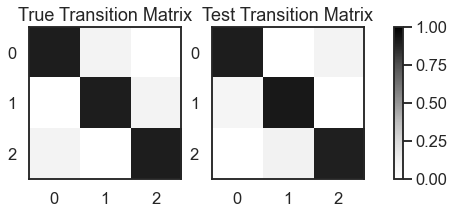

In [6]:
# Here, we compare the true and inferred transition matrix
compare_transition_matrix(true_hmm.transition_matrix, fitted_hmm.transition_matrix)

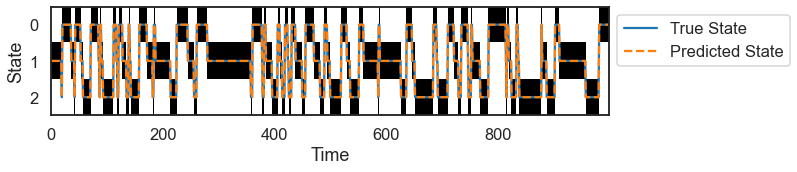

In [7]:
# Here, we plot the inferred state against the true state as a function of time. 
# The black rectangles represent the probability of the inferred state. We can 
# see that the model is very confident about the different state assignments.

plt.figure(figsize=(10, 2))
plt.imshow(Ez.T[perm, :], aspect="auto", interpolation="none", vmin=0, vmax=1, cmap="Greys")
plt.plot(states, '-', label="True State")
plt.plot(Ez.T[perm, :].argmax(axis=0), '--', label="Predicted State")
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Time")
plt.ylabel("State")
plt.show()

## Fit Gaussian HMM on Multiple Trials

In [8]:
rng = jr.PRNGKey(0)
num_steps = 1000
num_trials = 5

all_states, all_data = true_hmm.sample(rng, num_steps=num_steps, num_samples=num_trials)

In [9]:
# now we have a batch dim of `num_trials`
print(all_states.shape)
print(all_data.shape)

(5, 1000)
(5, 1000, 2)


In [10]:
# here, we fit across the entire dataset using EM
# this is implemented by vmapping over the batch dim of our dataset
lps, fitted_hmm, posteriors = test_hmm.fit(all_data, method="em")

Initializing...
initializing with kmeans
Done.


  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
# notice that our posteriors object has a batch dim for it's properties
# (one for each of the trials in our dataset)
print(posteriors.expected_states.shape)

(5, 1000, 3)


### Let's inspect our fitted model

With the additional trial examples, we notice that our model has recovered more of the true transition matrix!

In [12]:
posteriors.expected_transitions.sum(axis=0).round(1)

DeviceArray([[1354.,    0.,  168.],
             [ 168., 1744.,    0.],
             [   0.,  167., 1394.]], dtype=float32)

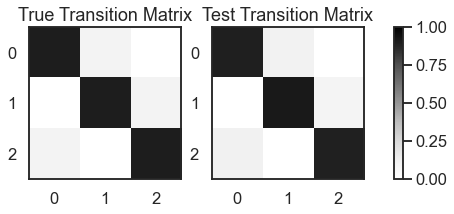

In [13]:
# Here, we compare the true and inferred transition matrix
compare_transition_matrix(true_hmm.transition_matrix, fitted_hmm.transition_matrix[np.ix_(perm, perm)])

# 2. Poisson HMM

### As before, let's create a true model

In [14]:
num_states = 5
num_channels = 10
initial_distribution = tfp.distributions.Categorical(logits=np.zeros(num_states))

transition_matrix = 0.90 * np.eye(num_states) + 0.10 * np.ones((num_states, num_states)) / num_states
transition_distribution = tfp.distributions.Categorical(probs=transition_matrix)

emission_means = tfp.distributions.Gamma(3.0, 1.0).sample(seed=jr.PRNGKey(0), sample_shape=(num_states, num_channels))
emission_distribution = tfp.distributions.Independent(tfp.distributions.Poisson(emission_means), reinterpreted_batch_ndims=1)

poisson_hmm = PoissonHMM(num_states, initial_distribution, transition_distribution, emission_distribution)

/Users/scott/miniconda3/envs/ssm_jax/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/Users/scott/miniconda3/envs/ssm_jax/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3070: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")
/Users/scott/miniconda3/en

### From the true model, we can sample synthetic data

In [15]:
rng = jr.PRNGKey(0)
num_timesteps = 500

# There's an annoying warning/bug when sampling from Poisson TFP distributions currently
# We can suppress the warning here for convenience
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", "Explicitly requested dtype")
    states, data = poisson_hmm.sample(rng, num_timesteps)

### Let's view the synthetic data

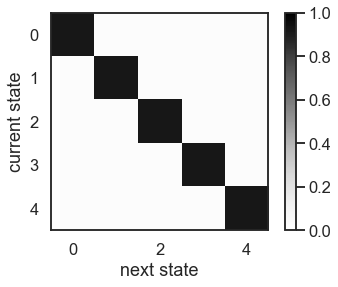

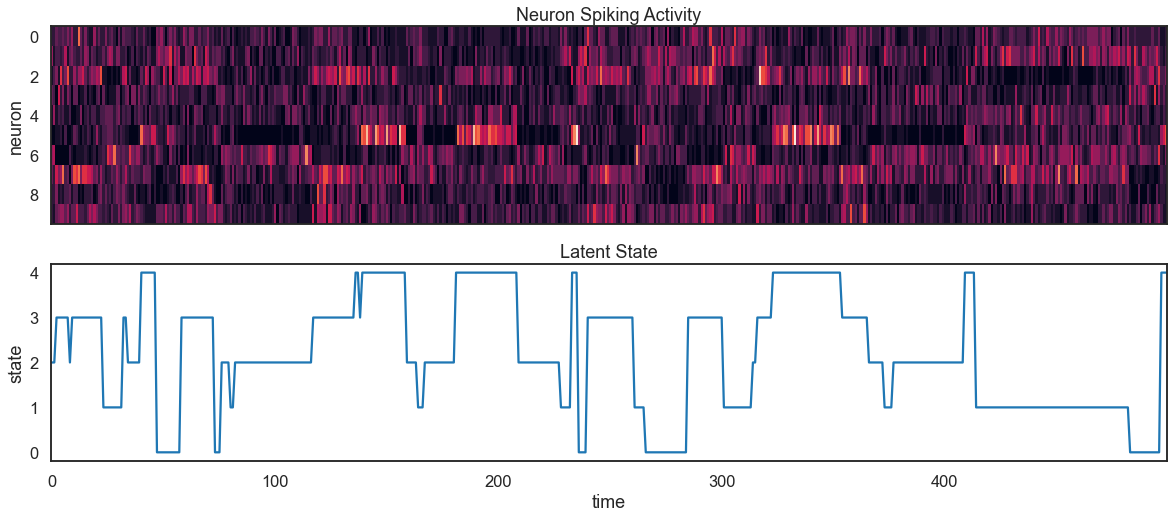

In [16]:
plot_transition_matrix(poisson_hmm.transition_matrix)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(20, 8))
axs[0].imshow(data.T, aspect="auto", interpolation="none")
axs[0].set_ylabel("neuron")
axs[0].set_title("Neuron Spiking Activity")
axs[1].plot(states)
axs[1].set_title("Latent State")
axs[1].set_xlabel("time")
axs[1].set_ylabel("state")
plt.show()

## Fit HMM using exact EM update

In [17]:
initial_distribution = tfp.distributions.Categorical(logits=np.zeros(num_states))
transition_distribution = tfp.distributions.Categorical(logits=np.zeros((num_states, num_states)))
emission_means = tfp.distributions.Gamma(3.0, 1.0).sample(seed=jr.PRNGKey(0), sample_shape=(num_states, num_channels))
emission_distribution = tfp.distributions.Independent(tfp.distributions.Poisson(emission_means), reinterpreted_batch_ndims=1)

test_hmm = PoissonHMM(num_states, initial_distribution, transition_distribution, emission_distribution)


lps, test_hmm, posterior = test_hmm.fit(data, method="em")

/Users/scott/miniconda3/envs/ssm_jax/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/Users/scott/miniconda3/envs/ssm_jax/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3070: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")
/Users/scott/miniconda3/en

Initializing...
initializing with kmeans
Done.


  0%|          | 0/100 [00:00<?, ?it/s]

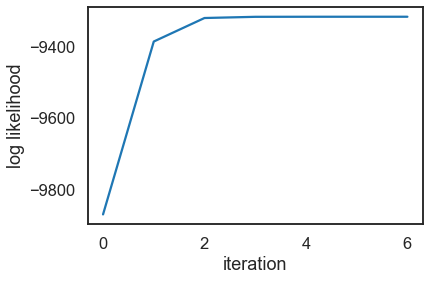

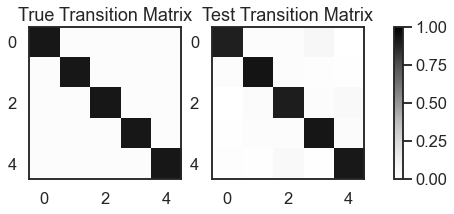

In [19]:
# Plot the log probabilities
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log likelihood")

# Compare the transition matrices
compare_transition_matrix(poisson_hmm.transition_matrix, test_hmm.transition_matrix)

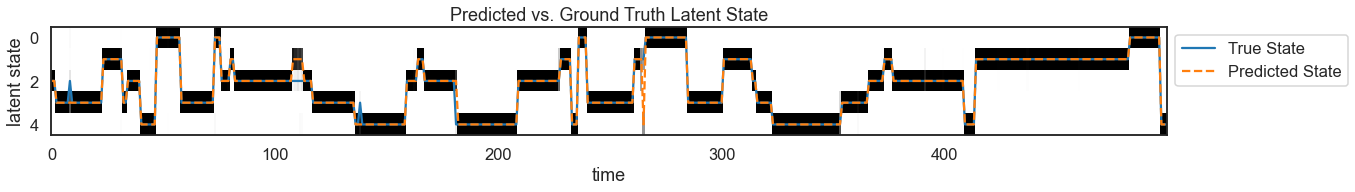

In [20]:
# Posterior distribution
Ez = posterior.expected_states.reshape(-1, num_states)
perm = find_permutation(states, np.argmax(Ez, axis=-1))
plot_posterior_states(Ez, states, perm)

## Fit Poisson HMM over multiple trials

In [21]:
rng = jr.PRNGKey(0)
num_timesteps = 500
num_trials = 5

# once again, we suppress the warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", "Explicitly requested dtype")
    all_states, all_data = poisson_hmm.sample(rng, num_timesteps, num_samples=num_trials)

In [22]:
# Now we have a batch dimension of size `num_trials`
print(all_states.shape)
print(all_data.shape)

(5, 500)
(5, 500, 10)


In [23]:
initial_distribution = tfp.distributions.Categorical(logits=np.zeros(num_states))
transition_distribution = tfp.distributions.Categorical(logits=np.zeros((num_states, num_states)))
emission_means = tfp.distributions.Gamma(3.0, 1.0).sample(seed=jr.PRNGKey(0), sample_shape=(num_states, num_channels))
emission_distribution = tfp.distributions.Independent(tfp.distributions.Poisson(emission_means), reinterpreted_batch_ndims=1)
test_hmm = GaussianHMM(num_states, initial_distribution, transition_distribution, emission_distribution)

lps, test_hmm, posterior = test_hmm.fit(all_data, method="em")

/Users/scott/miniconda3/envs/ssm_jax/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/Users/scott/miniconda3/envs/ssm_jax/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3070: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")
/Users/scott/miniconda3/en

Initializing...
initializing with kmeans
Done.


  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
initial_distribution = tfp.distributions.Categorical(logits=np.zeros(num_states))
transition_distribution = tfp.distributions.Categorical(logits=np.zeros((num_states, num_states)))
emission_means = tfp.distributions.Gamma(3.0, 1.0).sample(seed=jr.PRNGKey(0), sample_shape=(num_states, num_channels))
emission_distribution = tfp.distributions.Independent(tfp.distributions.Poisson(emission_means), reinterpreted_batch_ndims=1)
test_hmm = PoissonHMM(num_states, initial_distribution, transition_distribution, emission_distribution)

lps, test_hmm, posterior = test_hmm.fit(all_data, method="em")

/Users/scott/miniconda3/envs/ssm_jax/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:5847: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/Users/scott/miniconda3/envs/ssm_jax/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3070: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "array")
/Users/scott/miniconda3/en

Initializing...
initializing with kmeans
Done.


/Users/scott/miniconda3/envs/ssm_jax/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3185: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "ones")


  0%|          | 0/100 [00:00<?, ?it/s]

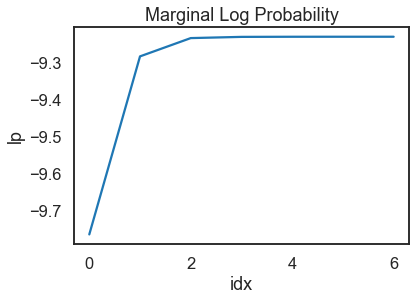

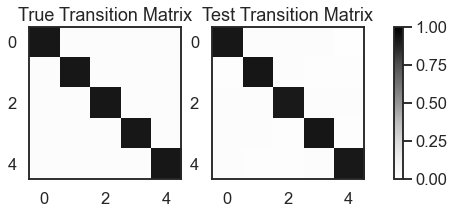

In [25]:
# plot marginal log probabilities
plt.title("Marginal Log Probability")
plt.ylabel("lp")
plt.xlabel("idx")
plt.plot(lps / data.size)

compare_transition_matrix(poisson_hmm.transition_matrix, test_hmm.transition_matrix)

===== Trial: 0 =====


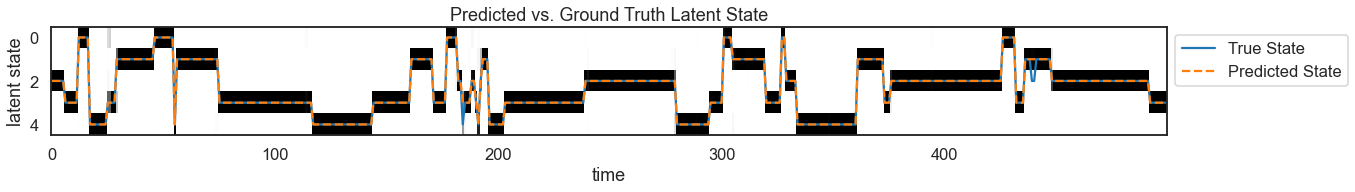

===== Trial: 1 =====


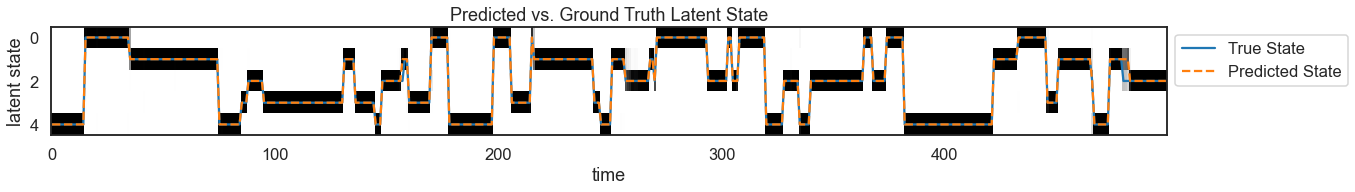

===== Trial: 2 =====


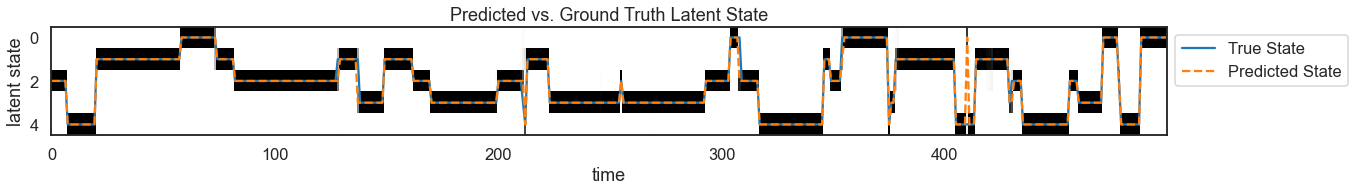

In [26]:
for trial_idx in range(3):
    print("="*5, f"Trial: {trial_idx}", "="*5)
    Ez = posterior.expected_states[trial_idx]
    states = all_states[trial_idx]
    perm = find_permutation(states, np.argmax(Ez, axis=-1))
    plot_posterior_states(Ez, states, perm)